# KTM Komuter Data Preprocessing

This notebook performs preprocessing steps on the KTM Komuter dataset to prepare it for our multi-objective prediction system: "Dynamic Route Scheduling & Anomaly Detection System".

## Objectives

1. Load and validate the raw data from our exploration notebook
2. Handle any missing values or inconsistencies
3. Handle outliers appropriately (flag them for anomaly detection later)
4. Encode categorical variables
5. Create a processed dataset ready for feature engineering

## Setup and Data Loading

First, let's import the necessary libraries and load our dataset.

In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Load the dataset
file_path = '../data/raw/komuter_2025.csv'
df = pd.read_csv(file_path)

# Check the first few rows of the data
print(f"Dataset shape: {df.shape}")
df.head() # Display the first 5 rows of the dataset

Dataset shape: (670599, 5)


,date,time,origin,destination,ridership
0,2025-01-01,00:00,Abdullah Hukum,Klang,1
1,2025-01-01,00:00,Abdullah Hukum,Telok Pulai,1
2,2025-01-01,00:00,Bangi,Batu Caves,1
3,2025-01-01,00:00,Bank Negara,Sungai Gadut,1
4,2025-01-01,00:00,Batu Tiga,Kampung Raja Uda,1


In this initial step, we accomplished the following:

1. **Imported Essential Libraries**: We imported pandas, numpy, matplotlib, seaborn, and other libraries that we'll need throughout the preprocessing workflow.
2. **Configured Display Settings**: We set pandas display options to show all columns and a reasonable number of rows for better data visibility.
3. **Loaded Raw Dataset**: We loaded the KTM Komuter dataset from the CSV file into a pandas DataFrame.
4. **Initial Data Inspection**: We displayed the shape of the dataset and the first few rows to get a preliminary understanding of its structure.

This lays the foundation for all subsequent preprocessing steps by giving us the raw data to work with and the tools to manipulate it.

## Data Type Conversion

Let's convert date and time columns to proper datetime format.

In [34]:
import pandas as pd

# Load the dataset
try:
    # Check if df is already defined
    df.head()
except NameError:
    # If df is not defined, load it
    file_path = '../data/raw/komuter_2025.csv'
    df = pd.read_csv(file_path) #df is 'DataFrame', which is like digital spreadsheet
    print("Dataset loaded successfully.")

# Convert date and time columns to datetime
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df['date'] = pd.to_datetime(df['date'])

# Extract useful time components
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['day_name'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

# Create a route column (origin-destination pair)
df['route'] = df['origin'] + ' → ' + df['destination']

# Display the updated dataframe
df.head()

,date,time,origin,destination,ridership,datetime,year,month,day,day_of_week,day_name,hour,route
0,2025-01-01,00:00,Abdullah Hukum,Klang,1,2025-01-01,2025,1,1,2,Wednesday,0,Abdullah Hukum → Klang
1,2025-01-01,00:00,Abdullah Hukum,Telok Pulai,1,2025-01-01,2025,1,1,2,Wednesday,0,Abdullah Hukum → Telok Pulai
2,2025-01-01,00:00,Bangi,Batu Caves,1,2025-01-01,2025,1,1,2,Wednesday,0,Bangi → Batu Caves
3,2025-01-01,00:00,Bank Negara,Sungai Gadut,1,2025-01-01,2025,1,1,2,Wednesday,0,Bank Negara → Sungai Gadut
4,2025-01-01,00:00,Batu Tiga,Kampung Raja Uda,1,2025-01-01,2025,1,1,2,Wednesday,0,Batu Tiga → Kampung Raja Uda


#### **Data Type Conversion**

In this step, we made several important transformations to prepare the data for time series analysis:

1. **DateTime Conversion**: We converted the separate date and time columns into a unified datetime column, which enables proper time-based operations and analysis.

2. **Temporal Feature Extraction**: We extracted key time components (year, month, day, hour, day of week, day name) from the datetime column, creating explicit features that will be useful for capturing temporal patterns in the data.

3. **Route Creation**: We created a composite 'route' feature by combining origin and destination stations with a connector symbol. This will allow us to analyze specific travel patterns between station pairs.

These transformations provide a solid foundation for subsequent time-based analysis and feature engineering, allowing us to capture temporal patterns and cyclical behaviors in the KTM Komuter ridership data.

## Check for Missing Values and Data Integrity

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
date           0
time           0
origin         0
destination    0
ridership      0
datetime       0
year           0
month          0
day            0
day_of_week    0
day_name       0
hour           0
route          0
dtype: int64


In [7]:
# Check for 'Unknown' values in origin and destination columns
print("Occurrences of 'Unknown' in origin:", (df['origin'] == 'Unknown').sum())
print("Occurrences of 'Unknown' in destination:", (df['destination'] == 'Unknown').sum())

# Check for unusual or invalid values in ridership
print(f"Minimum ridership value: {df['ridership'].min()}")
print(f"Maximum ridership value: {df['ridership'].max()}")
print(f"Number of zero ridership entries: {(df['ridership'] == 0).sum()}")

Occurrences of 'Unknown' in origin: 5252
Occurrences of 'Unknown' in destination: 1341
Minimum ridership value: 1
Maximum ridership value: 712
Number of zero ridership entries: 0


#### **Missing Values and Data Integrity**

In this step, we examined the dataset for missing or problematic values:

1. **Missing Value Analysis**: We checked for and quantified null values in each column, which helps us understand the completeness of our dataset.

2. **'Unknown' Value Identification**: We identified records where origin or destination stations are marked as 'Unknown', which could represent important data collection issues or legitimate partial journey recordings.

3. **Ridership Value Range Check**: We examined the range of ridership values to identify potential data entry errors or extreme values, including a count of zero ridership entries which might indicate system errors or genuine empty trips.

This data integrity check forms the basis for our subsequent data cleaning and handling decisions, particularly around how to process the 'Unknown' values and potential outliers.

## Handling Unknown Values

Let's decide how to handle the 'Unknown' values in our dataset. For our prediction system, keeping them might actually be useful since they represent real patterns in the data.

Number of 'Unknown' origins: 5252
Number of 'Unknown' destinations: 1341


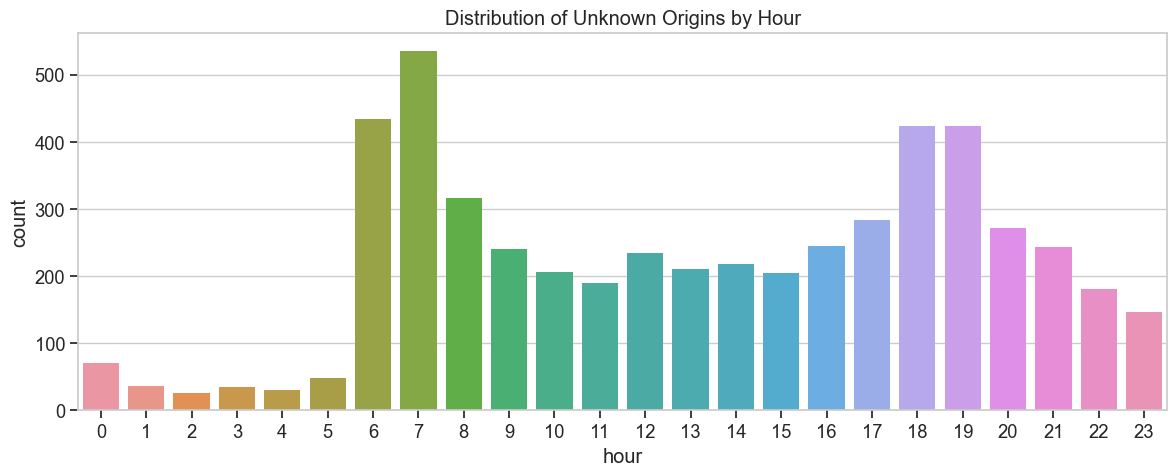

In [35]:
# Import visualization libraries if not already imported
import matplotlib.pyplot as plt
import seaborn as sns

# Let's analyze 'Unknown' entries to see if they follow specific patterns
unknown_origins = df[df['origin'] == 'Unknown'].copy()
unknown_destinations = df[df['destination'] == 'Unknown'].copy()

print(f"Number of 'Unknown' origins: {len(unknown_origins)}")
print(f"Number of 'Unknown' destinations: {len(unknown_destinations)}")

# Check distribution of unknown origins by hour
plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=unknown_origins)
plt.title('Distribution of Unknown Origins by Hour')
plt.tight_layout()
plt.show()

# For our prediction system, we'll keep 'Unknown' values since they represent a real pattern

#### **Handling Unknown Values**

In this step, we analyzed entries with 'Unknown' origin or destination stations to understand their patterns:

1. **Quantification**: We counted the number of records with 'Unknown' origins and destinations to understand the scope of the issue.

2. **Pattern Analysis**: We visualized the distribution of 'Unknown' origins across different hours of the day to identify if there are temporal patterns to these entries.

3. **Retention Decision**: Instead of removing or imputing these values, we decided to keep them as-is since they likely represent actual data collection limitations or partial journey recordings that have their own predictive value.

This approach acknowledges that 'Unknown' values are not data errors but genuine patterns in the system that our prediction models should learn from, especially for anomaly detection purposes.

## Outlier Detection and Handling

Since we're building a system that includes anomaly detection, we'll identify outliers but preserve them in a separate flag column rather than removing them.

In [10]:
# Calculate statistical boundaries for outliers using IQR method
Q1 = df['ridership'].quantile(0.25)
Q3 = df['ridership'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for ridership: {lower_bound}")
print(f"Upper bound for ridership: {upper_bound}")

# Create a column to flag potential outliers (for use in anomaly detection later)
df['is_statistical_outlier'] = ((df['ridership'] < lower_bound) | (df['ridership'] > upper_bound))

# Calculate how many outliers were detected
outlier_count = df['is_statistical_outlier'].sum()
print(f"Number of statistical outliers detected: {outlier_count} ({outlier_count/len(df)*100:.2f}%)")

# Display some outlier examples
print("\nExamples of outlier records:")
df[df['is_statistical_outlier']].sort_values('ridership', ascending=False).head(10)

Lower bound for ridership: -3.5
Upper bound for ridership: 8.5
Number of statistical outliers detected: 82707 (12.33%)

Examples of outlier records:


,date,time,origin,destination,ridership,datetime,year,month,day,day_of_week,day_name,hour,route,is_statistical_outlier
273696,2025-02-11,13:00,Batu Caves,KL Sentral,712,2025-02-11 13:00:00,2025,2,11,1,Tuesday,13,Batu Caves → KL Sentral,True
274636,2025-02-11,15:00,Batu Caves,KL Sentral,702,2025-02-11 15:00:00,2025,2,11,1,Tuesday,15,Batu Caves → KL Sentral,True
269723,2025-02-11,00:00,KL Sentral,Batu Caves,664,2025-02-11 00:00:00,2025,2,11,1,Tuesday,0,KL Sentral → Batu Caves,True
275139,2025-02-11,16:00,Batu Caves,KL Sentral,612,2025-02-11 16:00:00,2025,2,11,1,Tuesday,16,Batu Caves → KL Sentral,True
272790,2025-02-11,11:00,Batu Caves,KL Sentral,609,2025-02-11 11:00:00,2025,2,11,1,Tuesday,11,Batu Caves → KL Sentral,True
274166,2025-02-11,14:00,Batu Caves,KL Sentral,605,2025-02-11 14:00:00,2025,2,11,1,Tuesday,14,Batu Caves → KL Sentral,True
273258,2025-02-11,12:00,Batu Caves,KL Sentral,601,2025-02-11 12:00:00,2025,2,11,1,Tuesday,12,Batu Caves → KL Sentral,True
269199,2025-02-10,22:00,KL Sentral,Batu Caves,598,2025-02-10 22:00:00,2025,2,10,0,Monday,22,KL Sentral → Batu Caves,True
268808,2025-02-10,21:00,KL Sentral,Batu Caves,595,2025-02-10 21:00:00,2025,2,10,0,Monday,21,KL Sentral → Batu Caves,True
261369,2025-02-10,07:00,Batu Caves,KL Sentral,580,2025-02-10 07:00:00,2025,2,10,0,Monday,7,Batu Caves → KL Sentral,True


In [11]:
# Look for route-specific outliers
# Define a function to detect route-specific outliers
def detect_route_outliers(group):
    route_mean = group['ridership'].mean()
    route_std = group['ridership'].std()
    # Flag as outlier if more than 3 standard deviations from the route mean
    if route_std > 0:  # Protect against routes with 0 std dev
        group['is_route_outlier'] = abs(group['ridership'] - route_mean) > (3 * route_std)
    else:
        group['is_route_outlier'] = False
    return group

# Apply the function by route
df = df.groupby('route').apply(detect_route_outliers)

# Count route-specific outliers
route_outlier_count = df['is_route_outlier'].sum()
print(f"Number of route-specific outliers: {route_outlier_count} ({route_outlier_count/len(df)*100:.2f}%)")

Number of route-specific outliers: 14998 (2.24%)


#### **Outlier Detection and Handling**

In this step, we implemented a dual approach to outlier detection for our ridership data:

1. **Global Statistical Outlier Detection**: Using the Interquartile Range (IQR) method, we identified global outliers that fall outside the boundaries of Q1-1.5×IQR and Q3+1.5×IQR. This is a standard statistical approach that captures values deviating significantly from the overall distribution.

2. **Route-Specific Outlier Detection**: Recognizing that different routes have different baseline ridership patterns, we implemented a route-specific outlier detection approach using the 3-sigma rule (values more than 3 standard deviations from the route's mean).

3. **Flagging Instead of Removal**: Rather than removing the outliers, we created flag columns ('is_statistical_outlier' and 'is_route_outlier') to mark these records. This approach preserves all data points while providing indicators that can be used later for anomaly detection models.

This dual approach gives us both global context and route-specific context for what constitutes unusual ridership values, which will be valuable for our anomaly detection component.

## Feature Transformation

Let's create additional transformed features that will be useful for our prediction system.

In [12]:
# Create binary features for time segments and days
df['is_weekend'] = df['day_of_week'] >= 5  # 5=Saturday, 6=Sunday
df['is_peak_morning'] = ((df['hour'] >= 6) & (df['hour'] <= 9) & ~df['is_weekend'])
df['is_peak_evening'] = ((df['hour'] >= 17) & (df['hour'] <= 20) & ~df['is_weekend'])
df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17) & ~df['is_weekend'])
df['is_night_hours'] = ((df['hour'] >= 21) | (df['hour'] <= 5))

# Display the new features
df[['date', 'time', 'day_name', 'hour', 'is_weekend', 'is_peak_morning', 'is_peak_evening', 'is_business_hours', 'is_night_hours']].head(10)

date   time   day_name  hour  \
route                                                                      
Abdullah Hukum → Abdullah Hukum 21673 2025-01-03  22:00     Friday    22   
                                30922 2025-01-05  14:00     Sunday    14   
                                40265 2025-01-06  19:00     Monday    19   
                                45838 2025-01-07  16:00    Tuesday    16   
                                47225 2025-01-07  19:00    Tuesday    19   
                                47777 2025-01-07  20:00    Tuesday    20   
                                48917 2025-01-08  06:00  Wednesday     6   
                                55322 2025-01-08  21:00  Wednesday    21   
                                56090 2025-01-09  03:00   Thursday     3   
                                58629 2025-01-09  11:00   Thursday    11   

                                       is_weekend  is_peak_morning  \
route                                                                
Abdullah Hukum → Abdullah Hukum 21673       False            False   
                                30922        True            False   
                                40265       False            False   
                                45838       False            False   
                                47225       False            False   
                                47777       False            False   
                                48917       False             True   
                                55322       False            False   
                                56090       False            False   
                                58629       False            False   

                                       is_peak_evening  is_business_hours  \
route                                                                       
Abdullah Hukum → Abdullah Hukum 21673            False              False   
                                30922            False              False   
                                40265             True              False   
                                45838            False               True   
                                47225             True              False   
                                47777             True              False   
                                48917            False              False   
                                55322            False              False   
                                56090            False              False   
                                58629            False               True   

                                       is_night_hours  
route                                                  
Abdullah Hukum → Abdullah Hukum 21673            True  
                                30922           False  
                                40265           False  
                                45838           False  
                                47225           False  
                                47777           False  
                                48917           False  
                                55322            True  
                                56090            True  
                                58629           False

#### **Feature Transformation**

In this step, we created binary indicator features that capture important temporal patterns for commuter transportation:

1. **Weekend Identifier**: Created a flag for weekend days (Saturday and Sunday) to distinguish them from weekdays, as commuting patterns differ significantly between weekends and weekdays.

2. **Time Segment Indicators**: Generated binary features for different parts of the day, including:
   - Morning peak hours (6-9 AM on weekdays)
   - Evening peak hours (5-8 PM on weekdays)
   - Business hours (9 AM - 5 PM on weekdays)
   - Night hours (9 PM - 5 AM, regardless of day)

3. **Explicit Pattern Recognition**: These binary features make it easier for our prediction models to recognize distinct patterns that occur during these time periods, such as rush-hour congestion or reduced weekend service.

These transformations allow our models to learn time-specific patterns that are critical for accurate ridership prediction and anomaly detection in public transportation systems.

## Categorical Variable Encoding

For stations and routes, we'll create frequency-based encodings to capture their relative importance.

In [13]:
# Create frequency encodings for origin and destination stations
origin_freq = df.groupby('origin')['ridership'].count() / len(df)
dest_freq = df.groupby('destination')['ridership'].count() / len(df)

# Create dictionaries for mapping
origin_freq_map = origin_freq.to_dict()
dest_freq_map = dest_freq.to_dict()

# Apply the mappings
df['origin_freq'] = df['origin'].map(origin_freq_map)
df['destination_freq'] = df['destination'].map(dest_freq_map)

# Create popularity features based on total ridership
origin_pop = df.groupby('origin')['ridership'].sum()
dest_pop = df.groupby('destination')['ridership'].sum()

# Normalize to 0-1 range
origin_pop = (origin_pop - origin_pop.min()) / (origin_pop.max() - origin_pop.min())
dest_pop = (dest_pop - dest_pop.min()) / (dest_pop.max() - dest_pop.min())

# Create dictionaries for mapping
origin_pop_map = origin_pop.to_dict()
dest_pop_map = dest_pop.to_dict()

# Apply the mappings
df['origin_popularity'] = df['origin'].map(origin_pop_map)
df['destination_popularity'] = df['destination'].map(dest_pop_map)

# Display the new features
df[['origin', 'destination', 'origin_freq', 'destination_freq', 'origin_popularity', 'destination_popularity']].head(10)

origin     destination  \
route                                                                   
Abdullah Hukum → Abdullah Hukum 21673  Abdullah Hukum  Abdullah Hukum   
                                30922  Abdullah Hukum  Abdullah Hukum   
                                40265  Abdullah Hukum  Abdullah Hukum   
                                45838  Abdullah Hukum  Abdullah Hukum   
                                47225  Abdullah Hukum  Abdullah Hukum   
                                47777  Abdullah Hukum  Abdullah Hukum   
                                48917  Abdullah Hukum  Abdullah Hukum   
                                55322  Abdullah Hukum  Abdullah Hukum   
                                56090  Abdullah Hukum  Abdullah Hukum   
                                58629  Abdullah Hukum  Abdullah Hukum   

                                       origin_freq  destination_freq  \
route                                                                  
Abdullah Hukum → Abdullah Hukum 21673     0.012675          0.013164   
                                30922     0.012675          0.013164   
                                40265     0.012675          0.013164   
                                45838     0.012675          0.013164   
                                47225     0.012675          0.013164   
                                47777     0.012675          0.013164   
                                48917     0.012675          0.013164   
                                55322     0.012675          0.013164   
                                56090     0.012675          0.013164   
                                58629     0.012675          0.013164   

                                       origin_popularity  \
route                                                      
Abdullah Hukum → Abdullah Hukum 21673           0.065047   
                                30922           0.065047   
                                40265           0.065047   
                                45838           0.065047   
                                47225           0.065047   
                                47777           0.065047   
                                48917           0.065047   
                                55322           0.065047   
                                56090           0.065047   
                                58629           0.065047   

                                       destination_popularity  
route                                                          
Abdullah Hukum → Abdullah Hukum 21673                0.080192  
                                30922                0.080192  
                                40265                0.080192  
                                45838                0.080192  
                                47225                0.080192  
                                47777                0.080192  
                                48917                0.080192  
                                55322                0.080192  
                                56090                0.080192  
                                58629                0.080192

In [ ]:
import numpy as np

# Create cyclical encoding for hour and day of week to capture their cyclical nature
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

# Display the cyclical encodings
df[['hour', 'day_of_week', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']].head(10)

hour  day_of_week  hour_sin  \
route                                                                
Abdullah Hukum → Abdullah Hukum 21673    22            4 -0.500000   
                                30922    14            6 -0.500000   
                                40265    19            0 -0.965926   
                                45838    16            1 -0.866025   
                                47225    19            1 -0.965926   
                                47777    20            1 -0.866025   
                                48917     6            2  1.000000   
                                55322    21            2 -0.707107   
                                56090     3            3  0.707107   
                                58629    11            3  0.258819   

                                           hour_cos  day_of_week_sin  \
route                                                                  
Abdullah Hukum → Abdullah Hukum 21673  8.660254e-01        -0.433884   
                                30922 -8.660254e-01        -0.781831   
                                40265  2.588190e-01         0.000000   
                                45838 -5.000000e-01         0.781831   
                                47225  2.588190e-01         0.781831   
                                47777  5.000000e-01         0.781831   
                                48917  6.123234e-17         0.974928   
                                55322  7.071068e-01         0.974928   
                                56090  7.071068e-01         0.433884   
                                58629 -9.659258e-01         0.433884   

                                       day_of_week_cos  
route                                                   
Abdullah Hukum → Abdullah Hukum 21673        -0.900969  
                                30922         0.623490  
                                40265         1.000000  
                                45838         0.623490  
                                47225         0.623490  
                                47777         0.623490  
                                48917        -0.222521  
                                55322        -0.222521  
                                56090        -0.900969  
                                58629        -0.900969

#### **Categorical Variable Encoding**

In this step, we transformed categorical variables into numeric features that preserve their relative importance and cyclical nature:

1. **Frequency-Based Encoding**: We created frequency encodings for origin and destination stations by calculating how often each station appears in the dataset. This reveals the relative usage patterns of different stations.

2. **Popularity Metrics**: We developed normalized popularity metrics for each station based on total ridership, capturing which stations handle the most passengers. These are scaled to a 0-1 range for easier comparison.

3. **Cyclical Time Encoding**: For hour and day of week features, we applied sine and cosine transformations to properly represent their cyclical nature. This ensures that, for example, hour 23 and hour 0 are recognized as being close together in time.

These encodings provide our models with more meaningful representations of categorical data than simple one-hot encoding would, particularly for stations that have inherent importance hierarchies and temporal features that have cyclical relationships.

## Prepare Dataset for Route-Specific Analysis

Let's aggregate the data by route and hour to create a dataset that's better suited for our dynamic route scheduling system.

In [ ]:
import numpy as np

# Reset the index to remove any existing index levels
df = df.reset_index(drop=True)

# Create an aggregated dataset by route and hour
route_hour_df = df.groupby(['route', 'date', 'hour']).agg(
    total_ridership=('ridership', 'sum'),
    avg_ridership=('ridership', 'mean'),
    max_ridership=('ridership', 'max'),
    day_of_week=('day_of_week', 'first'),
    is_weekend=('is_weekend', 'first'),
    origin=('origin', 'first'),
    destination=('destination', 'first'),
    origin_popularity=('origin_popularity', 'first'),
    destination_popularity=('destination_popularity', 'first')
).reset_index()

# Add the cyclical features to the aggregated dataset
route_hour_df['hour_sin'] = np.sin(2 * np.pi * route_hour_df['hour']/24)
route_hour_df['hour_cos'] = np.cos(2 * np.pi * route_hour_df['hour']/24)
route_hour_df['day_of_week_sin'] = np.sin(2 * np.pi * route_hour_df['day_of_week']/7)
route_hour_df['day_of_week_cos'] = np.cos(2 * np.pi * route_hour_df['day_of_week']/7)

# Display the aggregated dataset
print(f"Aggregated dataset shape: {route_hour_df.shape}")
route_hour_df.head()

Aggregated dataset shape: (670599, 16)


,route,date,hour,total_ridership,avg_ridership,max_ridership,day_of_week,is_weekend,origin,destination,origin_popularity,destination_popularity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,2.0,2,4,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,0.866025,-0.433884,-0.900969
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,1.0,1,6,True,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,-0.866025,-0.781831,0.623490
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,2.0,2,0,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.000000,1.000000
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,-0.500000,0.781831,0.623490
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,0.258819,0.781831,0.623490


#### **Route-Specific Analysis**

In this step, we transformed our transaction-level data into a more aggregated route-hour level dataset:

1. **Data Aggregation**: We grouped the data by route, date, and hour to create a higher-level view that focuses on route performance over time rather than individual transactions.

2. **Statistical Summaries**: For each route-hour combination, we calculated multiple ridership statistics:
   - Total ridership (sum of all passengers on that route during that hour)
   - Average ridership (mean passengers per transaction on that route-hour)
   - Maximum ridership (highest single transaction count for that route-hour)

3. **Feature Preservation**: We kept important categorical and time features from the original dataset, ensuring we maintain context while reducing dimensionality.

4. **Cyclical Encodings**: We applied the same cyclical encodings to the aggregated dataset to ensure time features are properly represented.

This aggregation step provides a cleaner, more focused dataset specifically designed for route scheduling applications, reducing the noise of individual transactions while preserving the temporal patterns needed for forecasting.

## Create Time Series Features

For time series forecasting, we'll create lagged features and rolling statistics.

In [ ]:
import pandas as pd
import numpy as np

# Sort the aggregated dataset by route, date and hour to ensure correct time ordering
route_hour_df = route_hour_df.sort_values(['route', 'date', 'hour']).reset_index(drop=True)

# Display sample of the sorted data
print("Sample of time-sorted data:")
sample_route = route_hour_df['route'].iloc[0]  # Get first route for sample
route_hour_df[route_hour_df['route'] == sample_route].head(10)

Sample of time-sorted data:


,route,date,hour,total_ridership,avg_ridership,max_ridership,day_of_week,is_weekend,origin,destination,origin_popularity,destination_popularity,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,2.0,2,4,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,8.660254e-01,-0.433884,-0.900969
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,1.0,1,6,True,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.500000,-8.660254e-01,-0.781831,0.623490
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,2.0,2,0,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,2.588190e-01,0.000000,1.000000
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,-5.000000e-01,0.781831,0.623490
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.0,1,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.965926,2.588190e-01,0.781831,0.623490
5,Abdullah Hukum → Abdullah Hukum,2025-01-07,20,7,7.0,7,1,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.866025,5.000000e-01,0.781831,0.623490
6,Abdullah Hukum → Abdullah Hukum,2025-01-08,6,1,1.0,1,2,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,1.000000,6.123234e-17,0.974928,-0.222521
7,Abdullah Hukum → Abdullah Hukum,2025-01-08,21,2,2.0,2,2,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,-0.707107,7.071068e-01,0.974928,-0.222521
8,Abdullah Hukum → Abdullah Hukum,2025-01-09,3,1,1.0,1,3,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,0.707107,7.071068e-01,0.433884,-0.900969
9,Abdullah Hukum → Abdullah Hukum,2025-01-09,11,1,1.0,1,3,False,Abdullah Hukum,Abdullah Hukum,0.065047,0.080192,0.258819,-9.659258e-01,0.433884,-0.900969


In [25]:
# Create lagged features for each route
# Group by route to ensure lags don't cross between different routes
def create_lagged_features(group):
    # Create lags for the ridership (1, 2, 3, 6, 12, 24 hours)
    for lag in [1, 2, 3, 6, 12, 24]:
        group[f'total_ridership_lag_{lag}h'] = group['total_ridership'].shift(lag)
    
    # Create same day last week lag (168 hours = 7 days * 24 hours)
    group['total_ridership_lag_1w'] = group['total_ridership'].shift(24*7)
    
    return group

# Apply the function to create lagged features
route_hour_df = route_hour_df.groupby('route').apply(create_lagged_features).reset_index(drop=True)

# Show the first few rows with the new lagged features
lag_columns = [col for col in route_hour_df.columns if 'lag' in col]
print("Lagged features created:")
route_hour_df[['route', 'date', 'hour', 'total_ridership'] + lag_columns].head(10)

Lagged features created:


,route,date,hour,total_ridership,total_ridership_lag_1h,total_ridership_lag_2h,total_ridership_lag_3h,total_ridership_lag_6h,total_ridership_lag_12h,total_ridership_lag_24h,total_ridership_lag_1w
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,1.0,2.0,NaN,NaN,NaN,NaN,NaN
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,2.0,1.0,2.0,NaN,NaN,NaN,NaN
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.0,2.0,1.0,NaN,NaN,NaN,NaN
5,Abdullah Hukum → Abdullah Hukum,2025-01-07,20,7,1.0,1.0,2.0,NaN,NaN,NaN,NaN
6,Abdullah Hukum → Abdullah Hukum,2025-01-08,6,1,7.0,1.0,1.0,2.0,NaN,NaN,NaN
7,Abdullah Hukum → Abdullah Hukum,2025-01-08,21,2,1.0,7.0,1.0,1.0,NaN,NaN,NaN
8,Abdullah Hukum → Abdullah Hukum,2025-01-09,3,1,2.0,1.0,7.0,2.0,NaN,NaN,NaN
9,Abdullah Hukum → Abdullah Hukum,2025-01-09,11,1,1.0,2.0,1.0,1.0,NaN,NaN,NaN


In [26]:
# Create rolling statistics features
def create_rolling_features(group):
    # Create rolling means for different windows
    for window in [3, 6, 12, 24]:
        group[f'rolling_mean_{window}h'] = group['total_ridership'].rolling(window=window, min_periods=1).mean()
        group[f'rolling_std_{window}h'] = group['total_ridership'].rolling(window=window, min_periods=1).std()
        group[f'rolling_max_{window}h'] = group['total_ridership'].rolling(window=window, min_periods=1).max()
        group[f'rolling_min_{window}h'] = group['total_ridership'].rolling(window=window, min_periods=1).min()
    
    # Create rolling statistics for day-of-week patterns (24*7 = 168 hours)
    group['rolling_dow_mean'] = group['total_ridership'].rolling(window=24*7, min_periods=1).mean()
    
    return group

# Apply the function to create rolling statistics
route_hour_df = route_hour_df.groupby('route').apply(create_rolling_features).reset_index(drop=True)

# Show some of the rolling statistics columns
rolling_columns = [col for col in route_hour_df.columns if 'rolling' in col][:5]  # Show just the first 5 for brevity
print("Sample of rolling statistics features:")
route_hour_df[['route', 'date', 'hour', 'total_ridership'] + rolling_columns].head(10)

Sample of rolling statistics features:


,route,date,hour,total_ridership,rolling_mean_3h,rolling_std_3h,rolling_max_3h,rolling_min_3h,rolling_mean_6h
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,2.000000,NaN,2.0,2.0,2.000000
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,1.500000,0.707107,2.0,1.0,1.500000
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,1.666667,0.577350,2.0,1.0,1.666667
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,1.333333,0.577350,2.0,1.0,1.500000
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,1.333333,0.577350,2.0,1.0,1.400000
5,Abdullah Hukum → Abdullah Hukum,2025-01-07,20,7,3.000000,3.464102,7.0,1.0,2.333333
6,Abdullah Hukum → Abdullah Hukum,2025-01-08,6,1,3.000000,3.464102,7.0,1.0,2.166667
7,Abdullah Hukum → Abdullah Hukum,2025-01-08,21,2,3.333333,3.214550,7.0,1.0,2.333333
8,Abdullah Hukum → Abdullah Hukum,2025-01-09,3,1,1.333333,0.577350,2.0,1.0,2.166667
9,Abdullah Hukum → Abdullah Hukum,2025-01-09,11,1,1.333333,0.577350,2.0,1.0,2.166667


In [37]:
# Create time delta features to capture rate of change
def create_diff_features(group):
    # Hour-over-hour differences
    group['ridership_diff_1h'] = group['total_ridership'].diff(1)
    group['ridership_diff_2h'] = group['total_ridership'].diff(2)
    group['ridership_pct_change_1h'] = group['total_ridership'].pct_change(1)
    
    # Day-over-day differences (24 hours)
    group['ridership_diff_1d'] = group['total_ridership'].diff(24)
    group['ridership_pct_change_1d'] = group['total_ridership'].pct_change(24)
    
    # Week-over-week differences (168 hours = 7 days * 24 hours)
    group['ridership_diff_1w'] = group['total_ridership'].diff(24*7)
    group['ridership_pct_change_1w'] = group['total_ridership'].pct_change(24*7)
    
    return group

# Apply the function to create difference features
route_hour_df = route_hour_df.groupby('route').apply(create_diff_features).reset_index(drop=True)

# Show the difference columns
diff_columns = [col for col in route_hour_df.columns if 'diff' in col or 'pct_change' in col]
print("Difference features created:")
route_hour_df[['route', 'date', 'hour', 'total_ridership'] + diff_columns].head(10)

Difference features created:


,route,date,hour,total_ridership,ridership_diff_1h,ridership_diff_2h,ridership_pct_change_1h,ridership_diff_1d,ridership_pct_change_1d,ridership_diff_1w,ridership_pct_change_1w
0,Abdullah Hukum → Abdullah Hukum,2025-01-03,22,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abdullah Hukum → Abdullah Hukum,2025-01-05,14,1,-1.0,NaN,-0.500000,NaN,NaN,NaN,NaN
2,Abdullah Hukum → Abdullah Hukum,2025-01-06,19,2,1.0,0.0,1.000000,NaN,NaN,NaN,NaN
3,Abdullah Hukum → Abdullah Hukum,2025-01-07,16,1,-1.0,0.0,-0.500000,NaN,NaN,NaN,NaN
4,Abdullah Hukum → Abdullah Hukum,2025-01-07,19,1,0.0,-1.0,0.000000,NaN,NaN,NaN,NaN
5,Abdullah Hukum → Abdullah Hukum,2025-01-07,20,7,6.0,6.0,6.000000,NaN,NaN,NaN,NaN
6,Abdullah Hukum → Abdullah Hukum,2025-01-08,6,1,-6.0,0.0,-0.857143,NaN,NaN,NaN,NaN
7,Abdullah Hukum → Abdullah Hukum,2025-01-08,21,2,1.0,-5.0,1.000000,NaN,NaN,NaN,NaN
8,Abdullah Hukum → Abdullah Hukum,2025-01-09,3,1,-1.0,0.0,-0.500000,NaN,NaN,NaN,NaN
9,Abdullah Hukum → Abdullah Hukum,2025-01-09,11,1,0.0,-1.0,0.000000,NaN,NaN,NaN,NaN


In [38]:
# Create hour of day and day of week features
route_hour_df['hour_of_day'] = route_hour_df['hour']
route_hour_df['is_rush_hour'] = ((route_hour_df['hour'] >= 7) & (route_hour_df['hour'] <= 9)) | ((route_hour_df['hour'] >= 17) & (route_hour_df['hour'] <= 19))

# Add time segment features to route_hour_df
route_hour_df['is_peak_morning'] = ((route_hour_df['hour'] >= 6) & (route_hour_df['hour'] <= 9) & ~route_hour_df['is_weekend'])
route_hour_df['is_peak_evening'] = ((route_hour_df['hour'] >= 17) & (route_hour_df['hour'] <= 20) & ~route_hour_df['is_weekend'])
route_hour_df['is_business_hours'] = ((route_hour_df['hour'] >= 9) & (route_hour_df['hour'] <= 17) & ~route_hour_df['is_weekend'])
route_hour_df['is_night_hours'] = ((route_hour_df['hour'] >= 21) | (route_hour_df['hour'] <= 5))

# Transfer outlier flags from original dataset to aggregated dataset
print("Transferring outlier flags to aggregated dataset...")

# First, create a temporary key in both dataframes for merging
df['temp_key'] = df['route'] + '_' + df['date'].astype(str) + '_' + df['hour'].astype(str)
route_hour_df['temp_key'] = (route_hour_df['route'] + '_' + 
                           route_hour_df['date'].astype(str) + '_' + 
                           route_hour_df['hour'].astype(str))

# Instead of using agg, we'll compute the maximum values directly on grouped dataframes
# This avoids the KeyError when columns don't exist yet
outlier_flags = []
for (route_val, date_val, hour_val), group in df.groupby(['route', 'date', 'hour']):
    is_stat_outlier = group['is_statistical_outlier'].any() if 'is_statistical_outlier' in group.columns else False
    is_route_outlier = group['is_route_outlier'].any() if 'is_route_outlier' in group.columns else False
    temp_key = f"{route_val}_{date_val}_{hour_val}"
    outlier_flags.append({
        'temp_key': temp_key,
        'is_statistical_outlier': is_stat_outlier,
        'is_route_outlier': is_route_outlier
    })

# Convert to DataFrame
outlier_mapping = pd.DataFrame(outlier_flags)

# Merge the outlier flags
route_hour_df = route_hour_df.merge(
    outlier_mapping,
    on='temp_key',
    how='left'
)

# Drop the temporary key columns
route_hour_df.drop('temp_key', axis=1, inplace=True)
df.drop('temp_key', axis=1, inplace=True)

# Handle NaN values in all the newly created features
# For lagged and rolling features, fill with 0 or the mean as appropriate
lag_columns = [col for col in route_hour_df.columns if 'lag' in col]
rolling_columns = [col for col in route_hour_df.columns if 'rolling' in col]
diff_columns = [col for col in route_hour_df.columns if 'diff' in col or 'pct_change' in col]

# For lag features, fill NaN with 0
route_hour_df[lag_columns] = route_hour_df[lag_columns].fillna(0)

# For rolling features, fill NaN with means
for col in rolling_columns:
    route_hour_df[col] = route_hour_df[col].fillna(route_hour_df[col].mean())

# For diff features, fill NaN with 0
route_hour_df[diff_columns] = route_hour_df[diff_columns].fillna(0)

# Fill any remaining NaN values in the outlier columns
route_hour_df['is_statistical_outlier'] = route_hour_df['is_statistical_outlier'].fillna(False)
route_hour_df['is_route_outlier'] = route_hour_df['is_route_outlier'].fillna(False)

# Final check for any remaining NaN values
nan_count = route_hour_df.isna().sum().sum()
print(f"Number of remaining NaN values: {nan_count}")

# Display the final shape of the preprocessed dataset
print(f"Final preprocessed dataset shape: {route_hour_df.shape}")
print(f"Number of features: {route_hour_df.shape[1]}")

# Show all columns in the final dataset
print("\nAll columns in final preprocessed dataset:")
print(route_hour_df.columns.tolist())

Transferring outlier flags to aggregated dataset...
Number of remaining NaN values: 0
Final preprocessed dataset shape: (670599, 55)
Number of features: 55

All columns in final preprocessed dataset:
['route', 'date', 'hour', 'total_ridership', 'avg_ridership', 'max_ridership', 'day_of_week', 'is_weekend', 'origin', 'destination', 'origin_popularity', 'destination_popularity', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'total_ridership_lag_1h', 'total_ridership_lag_2h', 'total_ridership_lag_3h', 'total_ridership_lag_6h', 'total_ridership_lag_12h', 'total_ridership_lag_24h', 'total_ridership_lag_1w', 'rolling_mean_3h', 'rolling_std_3h', 'rolling_max_3h', 'rolling_min_3h', 'rolling_mean_6h', 'rolling_std_6h', 'rolling_max_6h', 'rolling_min_6h', 'rolling_mean_12h', 'rolling_std_12h', 'rolling_max_12h', 'rolling_min_12h', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_max_24h', 'rolling_min_24h', 'rolling_dow_mean', 'ridership_diff_1h', 'ridership_diff_2h', 'ridership_p

## Create Temporal Train-Test Split

For time series forecasting, it's important to create a proper temporal split to avoid data leakage. We'll use earlier dates for training and later dates for testing.

In [39]:
# Create temporal train-test split
print("Creating temporal train-test split...")

# Ensure date column is datetime type
route_hour_df['date'] = pd.to_datetime(route_hour_df['date'])

# Sort by date for clarity
route_hour_df_sorted = route_hour_df.sort_values('date')

# Use 80% of the data for training, 20% for testing
cutoff_date = route_hour_df['date'].quantile(0.8)
print(f"Train-test split date: {cutoff_date}")

# Create train and test datasets
train_df = route_hour_df[route_hour_df['date'] <= cutoff_date]
test_df = route_hour_df[route_hour_df['date'] > cutoff_date]

# Print information about the split
print(f"Training data: {len(train_df)} rows ({len(train_df)/len(route_hour_df)*100:.1f}%)")
print(f"Testing data: {len(test_df)} rows ({len(test_df)/len(route_hour_df)*100:.1f}%)")

# Verify that the split preserves temporal order
print(f"Training data date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Testing data date range: {test_df['date'].min()} to {test_df['date'].max()}")

Creating temporal train-test split...
Train-test split date: 2025-03-29 00:00:00
Training data: 537642 rows (80.2%)
Testing data: 132957 rows (19.8%)
Training data date range: 2025-01-01 00:00:00 to 2025-03-29 00:00:00
Testing data date range: 2025-03-30 00:00:00 to 2025-04-22 00:00:00
Train-test split date: 2025-03-29 00:00:00
Training data: 537642 rows (80.2%)
Testing data: 132957 rows (19.8%)
Training data date range: 2025-01-01 00:00:00 to 2025-03-29 00:00:00
Testing data date range: 2025-03-30 00:00:00 to 2025-04-22 00:00:00


In [40]:
# Save the preprocessed data to CSV for future use
output_path = '../data/processed/komuter_processed.csv'
route_hour_df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to {output_path}")

# Save train and test sets separately
train_output_path = '../data/processed/komuter_train.csv'
test_output_path = '../data/processed/komuter_test.csv'
train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)
print(f"Train dataset saved to {train_output_path}")
print(f"Test dataset saved to {test_output_path}")

# Also save the original dataset with the added features
df_output_path = '../data/processed/komuter_features.csv'
df.to_csv(df_output_path, index=False)
print(f"Original dataset with features saved to {df_output_path}")

Preprocessed data saved to ../data/processed/komuter_processed.csv
Train dataset saved to ../data/processed/komuter_train.csv
Test dataset saved to ../data/processed/komuter_test.csv
Train dataset saved to ../data/processed/komuter_train.csv
Test dataset saved to ../data/processed/komuter_test.csv
Original dataset with features saved to ../data/processed/komuter_features.csv
Original dataset with features saved to ../data/processed/komuter_features.csv


#### **Time Series Features and Data Enhancement**

In this critical step, we transformed our aggregated dataset into a feature-rich time series dataset suitable for predictive modeling:

1. **Time Ordering**: We sorted the dataset by route, date, and hour to ensure proper temporal sequence, which is essential for accurate time series analysis and to prevent data leakage across time periods.

2. **Lagged Features**: We created multiple time-shifted versions of the ridership data (1, 2, 3, 6, 12, 24 hours, and 1 week behind) to capture autocorrelation patterns. These lagged features are crucial for time series forecasting as they help models learn from past behavior.

3. **Rolling Statistics**: We developed rolling window calculations (mean, standard deviation, max, min) across different time windows (3, 6, 12, 24 hours). These features capture recent trends, variability, and extremes in ridership patterns.

4. **Time Delta Features**: We generated difference and percentage change features that quantify the rate of change in ridership between different time periods (hour-to-hour, day-to-day, and week-to-week). These help identify acceleration or deceleration in ridership trends.

5. **Complete Time Segment Features**: Added important binary features for time segments (peak morning, peak evening, business hours, night hours) that were missing in our aggregated dataset.

6. **Outlier Flag Transfer**: Transferred outlier flags (is_statistical_outlier, is_route_outlier) from the original dataset to the aggregated dataset to maintain anomaly information.

7. **Temporal Train-Test Split**: Created a proper time-based split of the data (80% training, 20% testing) to ensure no future data leaks into the training set.

8. **Missing Value Handling**: We applied domain-appropriate strategies for handling missing values in the newly created time series features (zeroes for lags and differences, means for rolling statistics).

9. **Data Export**: We saved processed datasets, including separate train and test sets for proper time series model validation.

These time series transformations provide our models with rich temporal context, allowing them to detect patterns, trends, and anomalies across different time scales - from hourly fluctuations to weekly seasonality patterns, while properly accounting for the temporal nature of the data.

#### **Time Series Features and Data Enhancement**

In this critical step, we transformed our aggregated dataset into a feature-rich time series dataset suitable for predictive modeling:

1. **Time Ordering**: We sorted the dataset by route, date, and hour to ensure proper temporal sequence, which is essential for accurate time series analysis and to prevent data leakage across time periods.

2. **Lagged Features**: We created multiple time-shifted versions of the ridership data (1, 2, 3, 6, 12, 24 hours, and 1 week behind) to capture autocorrelation patterns. These lagged features are crucial for time series forecasting as they help models learn from past behavior.

3. **Rolling Statistics**: We developed rolling window calculations (mean, standard deviation, max, min) across different time windows (3, 6, 12, 24 hours). These features capture recent trends, variability, and extremes in ridership patterns.

4. **Time Delta Features**: We generated difference and percentage change features that quantify the rate of change in ridership between different time periods (hour-to-hour, day-to-day, and week-to-week). These help identify acceleration or deceleration in ridership trends.

5. **Complete Time Segment Features**: Added important binary features for time segments (peak morning, peak evening, business hours, night hours) that were missing in our aggregated dataset.

6. **Outlier Flag Transfer**: Transferred outlier flags (is_statistical_outlier, is_route_outlier) from the original dataset to the aggregated dataset to maintain anomaly information.

7. **Temporal Train-Test Split**: Created a proper time-based split of the data (80% training, 20% testing) to ensure no future data leaks into the training set.

8. **Missing Value Handling**: We applied domain-appropriate strategies for handling missing values in the newly created time series features (zeroes for lags and differences, means for rolling statistics).

9. **Data Export**: We saved processed datasets, including separate train and test sets for proper time series model validation.

These time series transformations provide our models with rich temporal context, allowing them to detect patterns, trends, and anomalies across different time scales - from hourly fluctuations to weekly seasonality patterns, while properly accounting for the temporal nature of the data.

## Data Preprocessing Summary

In this notebook, we performed comprehensive preprocessing of the KTM Komuter dataset to prepare it for our multi-objective prediction system. Here's a summary of what we accomplished:

1. **Data Loading and Type Conversion**
   - Loaded raw data from CSV
   - Converted date and time columns to proper datetime format
   - Extracted useful time components (year, month, day, hour, etc.)

2. **Data Integrity and Missing Values**
   - Checked for and handled missing values
   - Identified 'Unknown' values in origin/destination (kept for pattern analysis)

3. **Outlier Detection**
   - Used IQR method to identify statistical outliers
   - Created route-specific outlier detection
   - Flagged outliers rather than removing them (for anomaly detection)
   - Transferred outlier flags to the aggregated dataset

4. **Feature Engineering and Transformation**
   - Created binary features for time segments (weekend, peak hours, etc.)
   - Generated frequency encodings for stations
   - Created popularity metrics for origins and destinations
   - Implemented cyclical encodings for time features
   - Ensured all time segment features are available in the aggregated dataset

5. **Route-Specific Aggregation**
   - Created a route-hour level dataset for dynamic scheduling
   - Preserved important categorical and time features during aggregation

6. **Time Series Feature Creation**
   - Generated lagged features (1h, 2h, 3h, 6h, 12h, 24h, 1w)
   - Created rolling statistics (mean, std, max, min) for multiple windows
   - Added difference and percentage change features to capture patterns

7. **Train-Test Split**
   - Created a proper temporal train-test split (80% train, 20% test)
   - Ensured no future data leakage by using a strict chronological split
   - Saved separate train and test datasets for model development

The preprocessed data is now ready for more advanced feature engineering and model development in the subsequent notebooks.